In [1]:
import pandas as pd
from sklearn.datasets import load_diabetes
import torch
import matplotlib.pyplot as plt

In [61]:
X, y = load_diabetes(as_frame=True, return_X_y=True, scaled=True)
feature_names = list(X.columns)

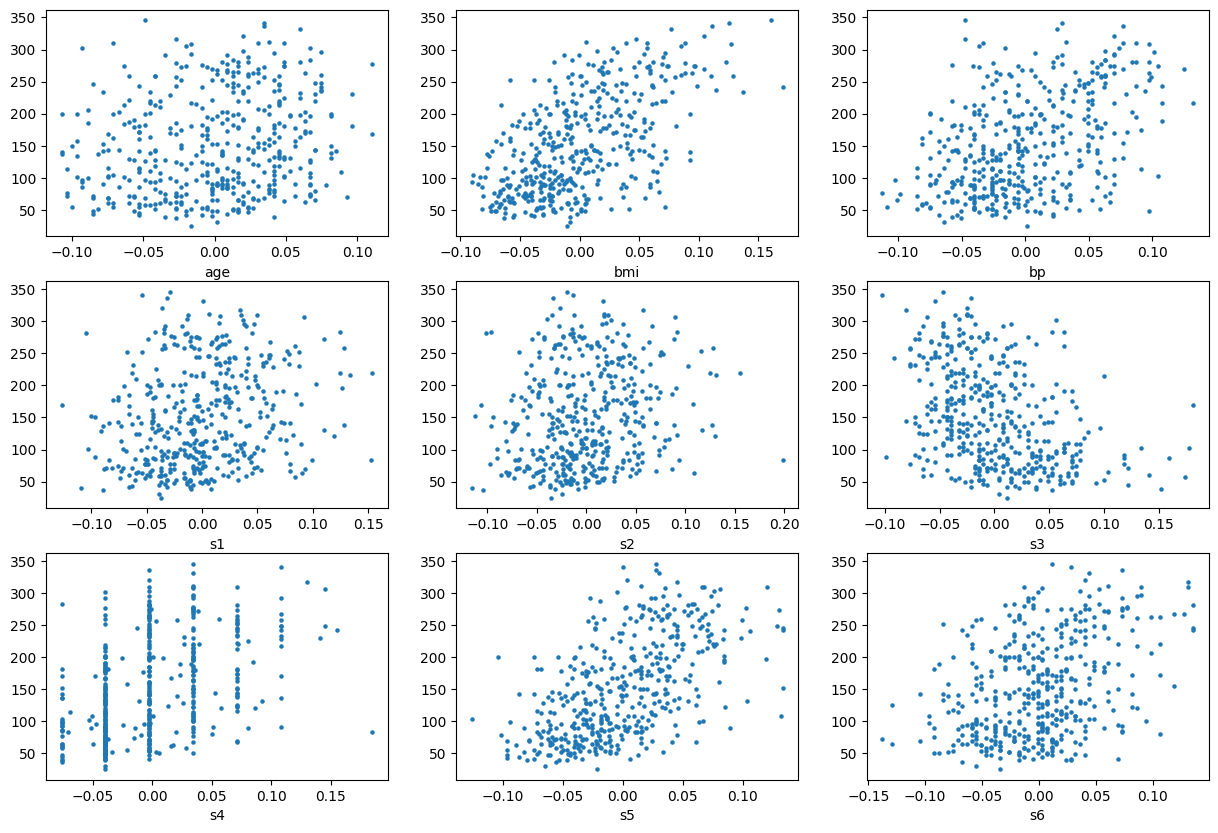

In [62]:
feats_plot = list(feature_names)
feats_plot.remove('sex')

fig, ax = plt.subplots(3,3, figsize=(15,10))
for i in range(3):
    for j in range(3):
        p_idx =  3 * i + j
        feat = feats_plot[p_idx]
        X_feat = X[feat].values
        # X_feat = X[:, p_idx]

        ax[i,j].scatter(X_feat, y, s=5)
        ax[i,j].set(xlabel=feats_plot[p_idx])

In [63]:
n_test = 50

to_t = lambda df: torch.tensor(df.values, dtype=torch.float)

X_train = to_t(X.iloc[:-n_test])
X_test = to_t(X.iloc[-n_test:])
y_train = to_t(y.iloc[:-n_test])
y_test = to_t(y.iloc[-n_test:])

In [64]:
in_features = X_train.shape[1]
out_features = 1
model_linear = torch.nn.Sequential(
    torch.nn.Linear(in_features, out_features, bias=True),
    torch.nn.Flatten(start_dim=0, end_dim=1),
)

loss_fn = torch.nn.MSELoss(reduction='mean')
# loss_fn = torch.nn.L1Loss(reduction='mean')

In [65]:
def get_mse_l2_loss(lambda_2):
    def mse_l2_loss(y_true, y_pred, bias, weights):
        loss = torch.mean(torch.pow((y_true - y_pred),2))
        loss += lambda_2 * torch.abs(weights).sum() / 2
        return loss
    return mse_l2_loss

loss_fn = get_mse_l2_loss(3.0)    

In [66]:
lr = 1e-3
n_epochs = 3_000
losses = torch.zeros(n_epochs)

for t in range(n_epochs):
    # forward pass
    y_pred = model_linear.forward(X_train)
    
    # calc loss
    # loss = loss_fn(y_pred, y_train)
    loss = loss_fn(y_pred, y_train, model_linear[0].bias, model_linear[0].weight)
    with torch.no_grad():
        losses[t] = loss.item()

    # backprop
    model_linear.zero_grad()  # object method
    loss.backward()

    with torch.no_grad():
        for p in model_linear.parameters():
            p -= lr * p.grad

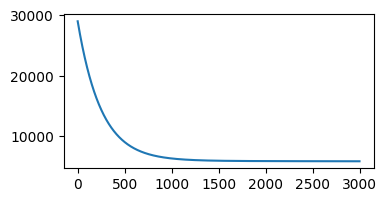

In [67]:
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(losses)
plt.show()

In [68]:
linear_layer = model_linear[0]
params = list(linear_layer.weight[0].detach().numpy())
for n, p in zip(
    ['bias'] + feature_names, [linear_layer.bias.item()] + params):
    print(f"{n:<8} {p:>6.3f}")

bias     151.667
age       0.000
sex      -0.000
bmi       7.809
bp        4.734
s1        0.460
s2        0.001
s3       -4.221
s4        5.388
s5        7.409
s6        4.428


In [38]:
with torch.no_grad():
    y_test_pred = model_linear.forward(X_test)
    loss_test = loss_fn(y_test, y_test_pred)
    # loss_test = loss_fn(y_test, y_test_pred, model_linear[0].bias, model_linear[0].weight)

print(f"Training loss: {losses[-1]:>12.3f}")
print(f"Test loss:     {loss_test:>12.3f}")

Training loss:     5714.865
Test loss:         5684.156


In [39]:
y_test_pred

tensor([151.4066, 149.0243, 155.1062, 150.8023, 148.3923, 151.5228, 151.8191,
        153.5124, 151.2257, 148.7573, 153.3305, 153.7585, 151.7418, 153.9779,
        146.8758, 152.6113, 153.8069, 153.7645, 152.7701, 149.6346, 154.2594,
        150.2374, 154.8762, 152.7862, 153.5736, 150.7938, 151.1565, 148.4895,
        152.2253, 154.3661, 153.6357, 153.4155, 152.8006, 147.6155, 154.3171,
        150.4679, 156.4322, 149.9170, 151.0212, 150.6140, 154.5099, 148.7551,
        150.9609, 150.2187, 147.1629, 153.2592, 152.1966, 151.3139, 152.8520,
        148.4960])

In [44]:
from typing import List

class LinReg(torch.nn.Module):

    def __init__(self, in_features: int, out_features: int, bias: bool, feature_names: List[str] = []):
        super().__init__()
        self.linear = torch.nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.flatten = torch.nn.Flatten(start_dim=0, end_dim=1)
        self.feature_names = feature_names
        self.bias_ = bias

    def forward(self, x):
        x = self.linear(x)
        x = self.flatten(x)
        return x

    def get_parameters(self):
        if len(self.feature_names)>0:
            keys = self.feature_names
        else:
            keys = list(range(len(self.linear.weight[0])))
        vals = list(self.linear.weight[0].detach().numpy())
        
        if self.bias_:
            keys = ['bias'] + keys
            vals = [self.linear.bias.item()] + vals
        

        return {k:v for k,v in zip(keys, vals)}
        

def get_mse_l2_loss(lambda_2):
    def MSELossL2(y_true, y_pred, model):
        bias = model.linear.bias.item()
        weights = model.linear.weight[0].detach()
        loss = torch.mean(torch.pow((y_true - y_pred),2))
        loss += lambda_2 * torch.abs(weights).sum() / 2.0
        return loss
    return MSELossL2


def train_loop(
    model,
    loss_fn,
    X_train: torch.tensor,
    y_train: torch.tensor,
    n_epochs: int = 100,
    lr: float = 1e-2,
    ):
    
    losses = torch.zeros(n_epochs, requires_grad=False)

    for t in range(n_epochs):
        # forward pass
        y_pred = model(X_train)

        # calc loss
        loss = loss_fn(y_pred, y_train)

        # backprop
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
            losses[t] = loss.item()
    return model, losses

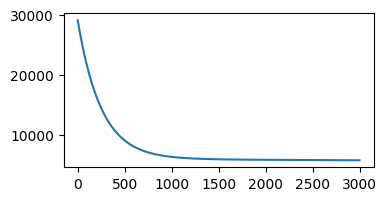

{'bias': 151.670166015625, 'age': 4.0008283, 'sex': 0.8181877, 'bmi': 12.109756, 'bp': 9.07389, 's1': 4.680406, 's2': 3.8287804, 's3': -8.19891, 's4': 9.30714, 's5': 11.736456, 's6': 8.455758}


In [45]:
model = LinReg(10, 1, True, feature_names=feature_names)
loss_fn = torch.nn.MSELoss(reduction='mean')
# loss_fn = get_mse_l2_loss(10.0)

model, losses = train_loop(
    model,
    loss_fn,
    X_train,
    y_train,
    n_epochs=3_000,
    lr=1e-3,
    )

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(losses)
plt.show()

print(model.get_parameters())

In [47]:
with torch.no_grad():
    y_test_pred = model.forward(X_test)

(array([5., 4., 3., 4., 2., 3., 2., 3., 1., 3., 5., 1., 2., 1., 2., 1., 3.,
        3., 0., 2.]),
 array([-106.49421692,  -93.49116516,  -80.4881134 ,  -67.48506165,
         -54.48200607,  -41.47895432,  -28.47590256,  -15.47284889,
          -2.46979666,   10.53325558,   23.53630829,   36.53936005,
          49.5424118 ,   62.54546738,   75.54851532,   88.55157471,
         101.55462646,  114.55767822,  127.56072998,  140.56378174,
         153.5668335 ]),
 <BarContainer object of 20 artists>)

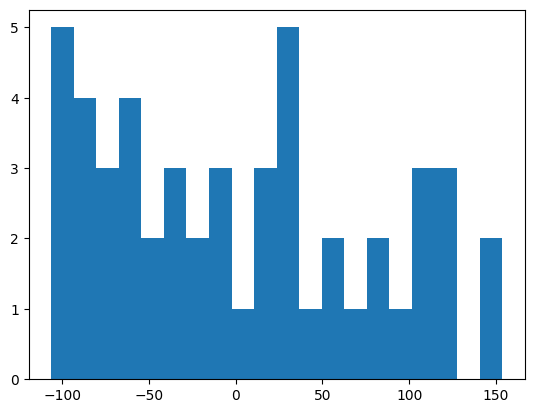

In [51]:
plt.hist((y_test - y_test_pred).numpy(), bins=20)

### Try with more layers, and nonlinearities